In [ ]:
# %% ===============================================================
# STEP 0 — ENVIRONMENT SETUP
# Purpose: Import packages, define paths, and configure visualization style.
# ===============================================================

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import joblib
import json
import warnings
import statsmodels.api as sm
import statsmodels.formula.api as smf

# ===============================================================
# GENERAL CONFIGURATION
# ===============================================================

# Clean logging
warnings.filterwarnings("ignore")

# Visualization style
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("viridis")

# ===============================================================
# DIRECTORY PATHS (CONSISTENT ACROSS ALL NOTEBOOKS)
# ===============================================================

BASE_DIR = Path("..")
DATA_PROCESSED = BASE_DIR / "data" / "processed"
OUTPUTS = BASE_DIR / "outputs"
FIGURES = OUTPUTS / "figures"
MODELS = OUTPUTS / "models"
MODELS_SARIMAX = MODELS / "sarimax"
REPORTS = OUTPUTS / "reports"

# Create all required directories
for path in [DATA_PROCESSED, FIGURES, MODELS, MODELS_SARIMAX, REPORTS]:
    path.mkdir(parents=True, exist_ok=True)

print("✅ Environment setup complete.")

✅ Environment setup complete.


In [2]:
# %% ===============================================================
# STEP 1 — LOAD FORECAST MODELS AND BASELINE DATA
# Purpose: Load trained models (SARIMAX, XGBoost, LightGBM)
#          and baseline feature and prediction datasets.
# ===============================================================

# ---------------------------------------------------------------
# 🔹 Load processed datasets
# ---------------------------------------------------------------
FEATURES_PATH = DATA_PROCESSED / "hotel_features.csv"
PRED_PATH = DATA_PROCESSED / "hotel_predictions.csv"

df_features = pd.read_csv(FEATURES_PATH, parse_dates=["month"])
df_preds = pd.read_csv(PRED_PATH, parse_dates=["month"])

print(f"✅ Features loaded: {df_features.shape[0]} rows × {df_features.shape[1]} columns")
print(f"✅ Predictions loaded: {df_preds.shape[0]} rows × {df_preds.shape[1]} columns")

# ---------------------------------------------------------------
# 🔹 Load trained models
# ---------------------------------------------------------------
MODEL_DIR = MODELS
SARIMAX_DIR = MODELS_SARIMAX

try:
    pipe_xgb = joblib.load(MODEL_DIR / "pipe_xgb.pkl")
    pipe_lgbm = joblib.load(MODEL_DIR / "pipe_lgbm.pkl")
    print("✅ ML models loaded successfully (XGBoost, LightGBM).")
except FileNotFoundError:
    print("⚠️ Warning: ML model files not found in /outputs/models/. Check file paths.")

# Load SARIMAX models (per-country)
sarimax_models = {}
for file in SARIMAX_DIR.glob("sarimax_*.pkl"):
    country = file.stem.replace("sarimax_", "")
    try:
        sarimax_models[country] = joblib.load(file)
    except Exception as e:
        print(f"⚠️ Failed to load SARIMAX model for {country}: {e}")

print(f"✅ SARIMAX models loaded: {len(sarimax_models)} countries")

# ---------------------------------------------------------------
# 🔹 Merge predictions with feature dataset
# ---------------------------------------------------------------
panel = df_features.merge(
    df_preds,
    on=["region", "month"],
    how="left",
    validate="m:1"
)

print(f"✅ Combined panel ready: {panel.shape}")
panel.head()

✅ Features loaded: 3328 rows × 39 columns
✅ Predictions loaded: 3328 rows × 47 columns
✅ ML models loaded successfully (XGBoost, LightGBM).
✅ SARIMAX models loaded: 26 countries
✅ Combined panel ready: (3328, 84)


,region,month,year_x,nights_spent_x,gdp_lag1_x,gdp_lag2_x,gdp_lag3_x,unemployment_rate_lag1_x,unemployment_rate_lag2_x,unemployment_rate_lag3_x,...,gdp_mom_y,turnover_index_mom_y,hicp_index_mom_y,m,quarter,yhat_naive,yhat_arimax,yhat_sarimax,yhat_xgb,yhat_lgbm
0,AT,2015-01-31,2015,1833949.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1,1,NaN,-1.336710e+07,1.013423e+07,NaN,NaN
1,AT,2015-02-28,2015,2145686.0,61688.900000,NaN,NaN,5.5,NaN,NaN,...,0.684456,0.0,0.274167,2,1,1833949.0,6.267903e+05,3.677250e+06,NaN,NaN
2,AT,2015-03-31,2015,1934635.0,62111.133333,61688.900000,NaN,5.9,5.5,NaN,...,0.679803,0.0,1.417722,3,1,2145686.0,2.478934e+06,7.914672e+05,NaN,NaN
3,AT,2015-04-30,2015,1468507.0,62533.366667,62111.133333,61688.900000,5.4,5.9,5.5,...,0.675213,0.0,0.129805,4,2,1934635.0,1.726522e+06,3.291706e+06,NaN,NaN
4,AT,2015-05-31,2015,1792973.0,62955.600000,62533.366667,62111.133333,5.6,5.4,5.9,...,0.631291,0.0,0.169525,5,2,1468507.0,1.470752e+06,2.722703e+05,NaN,NaN


In [3]:
# %% ===============================================================
# STEP 2 — SCENARIO DESIGN
# Purpose: Define macroeconomic scenarios for 2025–2026 to simulate
#          alternative demand outcomes (Baseline, Optimistic, Recession).
# ===============================================================

# ---------------------------------------------------------------
# 🔹 Define forecast horizon
# ---------------------------------------------------------------
future_months = pd.date_range(start="2025-01-01", end="2026-12-01", freq="MS")
regions = panel["region"].unique()

# ---------------------------------------------------------------
# 🔹 Core macroeconomic variables used in models
# ---------------------------------------------------------------
drivers = ["gdp_mom", "turnover_index_mom", "hicp_index_mom", "unemployment_rate_lag1"]

# ---------------------------------------------------------------
# 🔹 Scenario multipliers (relative % adjustments)
# These reflect plausible macroeconomic trajectories.
# ---------------------------------------------------------------
scenario_defs = {
    "Baseline": {
        "gdp_mom": 1.00,
        "turnover_index_mom": 1.00,
        "hicp_index_mom": 1.00,
        "unemployment_rate_lag1": 1.00,
    },
    "Optimistic": {
        "gdp_mom": 1.15,
        "turnover_index_mom": 1.10,
        "hicp_index_mom": 0.95,
        "unemployment_rate_lag1": 0.90,
    },
    "Recession": {
        "gdp_mom": 0.85,
        "turnover_index_mom": 0.90,
        "hicp_index_mom": 1.10,
        "unemployment_rate_lag1": 1.20,
    },
}

# ---------------------------------------------------------------
# 🔹 Create scenario dataframes
# ---------------------------------------------------------------
scenarios = {}
for name, factors in scenario_defs.items():
    temp = (
        panel.query("month >= '2024-01-01'")
        .groupby("region", group_keys=False)
        .tail(1)
        .copy()
    )
    temp = temp.loc[temp.index.repeat(len(future_months))].copy()
    temp["month"] = np.tile(future_months, len(regions))

    # Apply adjustments
    for var, factor in factors.items():
        if var in temp.columns:
            temp[var] = temp[var] * factor

    temp["scenario"] = name
    scenarios[name] = temp

# Combine all into one scenario panel
scenario_panel = pd.concat(scenarios.values(), ignore_index=True)
print(f"✅ Scenario panel created: {scenario_panel.shape[0]} rows × {scenario_panel.shape[1]} columns")
print(f"📅 Horizon: {future_months.min().strftime('%Y-%m')} → {future_months.max().strftime('%Y-%m')}")
print(f"📈 Scenarios: {list(scenarios.keys())}")
scenario_panel.head()

✅ Scenario panel created: 1872 rows × 85 columns
📅 Horizon: 2025-01 → 2026-12
📈 Scenarios: ['Baseline', 'Optimistic', 'Recession']


,region,month,year_x,nights_spent_x,gdp_lag1_x,gdp_lag2_x,gdp_lag3_x,unemployment_rate_lag1_x,unemployment_rate_lag2_x,unemployment_rate_lag3_x,...,turnover_index_mom_y,hicp_index_mom_y,m,quarter,yhat_naive,yhat_arimax,yhat_sarimax,yhat_xgb,yhat_lgbm,scenario
0,AT,2025-01-01,2025,3085257.0,69101.6,69101.6,69101.6,5.3,5.4,4.7,...,0.0,0.31682,8,3,2733547.0,2.615774e+06,2.937579e+06,NaN,NaN,Baseline
1,AT,2025-02-01,2025,3085257.0,69101.6,69101.6,69101.6,5.3,5.4,4.7,...,0.0,0.31682,8,3,2733547.0,2.615774e+06,2.937579e+06,NaN,NaN,Baseline
2,AT,2025-03-01,2025,3085257.0,69101.6,69101.6,69101.6,5.3,5.4,4.7,...,0.0,0.31682,8,3,2733547.0,2.615774e+06,2.937579e+06,NaN,NaN,Baseline
3,AT,2025-04-01,2025,3085257.0,69101.6,69101.6,69101.6,5.3,5.4,4.7,...,0.0,0.31682,8,3,2733547.0,2.615774e+06,2.937579e+06,NaN,NaN,Baseline
4,AT,2025-05-01,2025,3085257.0,69101.6,69101.6,69101.6,5.3,5.4,4.7,...,0.0,0.31682,8,3,2733547.0,2.615774e+06,2.937579e+06,NaN,NaN,Baseline


In [8]:
# %% ===============================================================
# STEP 3 — SCENARIO FORECASTING WITH ML AND SARIMAX MODELS
# Purpose: Generate forecasts for baseline, optimistic, and recession scenarios
# using trained XGBoost, LightGBM, and SARIMAX models.
# ===============================================================

# ===============================================================
# 1️⃣ LOAD BASE FEATURE MATRIX AND METADATA
# ===============================================================
base_features = pd.read_csv(DATA_PROCESSED / "train_features_for_shap.csv")
meta = pd.read_csv(DATA_PROCESSED / "hotel_features.csv", usecols=["region", "month"])

# Merge and remove duplicates
base_features = pd.concat([meta.reset_index(drop=True), base_features.reset_index(drop=True)], axis=1)
base_features = base_features.loc[:, ~base_features.columns.duplicated()]

# ===============================================================
# 2️⃣ DEFINE SCENARIOS
# ===============================================================
scenarios = {
    "Baseline": base_features.copy(),
    "Optimistic": base_features.copy(),
    "Recession": base_features.copy()
}

# Apply macro adjustments
scenarios["Optimistic"]["gdp_mom"] *= 1.05
scenarios["Optimistic"]["turnover_index_mom"] *= 1.03
scenarios["Optimistic"]["unemployment_rate_lag1"] *= 0.97

scenarios["Recession"]["gdp_mom"] *= 0.95
scenarios["Recession"]["turnover_index_mom"] *= 0.97
scenarios["Recession"]["unemployment_rate_lag1"] *= 1.05

# ===============================================================
# 3️⃣ CREATE LAGS SAFELY
# ===============================================================
def create_lags(df, vars_to_lag, max_lag=3):
    """Generate lagged features only for variables that exist."""
    df = df.sort_values(["region", "month"]).copy()
    for var in vars_to_lag:
        if var not in df.columns:
            continue
        for lag in range(1, max_lag + 1):
            df[f"{var}_lag{lag}"] = df.groupby("region")[var].shift(lag)
    return df

vars_to_lag = [
    "gdp_mom", "turnover_index_mom", "hicp_index_mom",
    "eurusd", "eurgbp", "covid_cases",
    "policy_stringency", "unemployment_rate"
]

scenarios_lagged = {name: create_lags(df, vars_to_lag) for name, df in scenarios.items()}

# ===============================================================
# 4️⃣ ENSURE RAW MODEL INPUT COLUMNS EXIST
# ===============================================================
ml_input_cols = [
    "region",
    "gdp_mom", "turnover_index_mom", "hicp_index_mom",
    "gdp_lag1", "turnover_index_lag1", "hicp_index_lag1",
    "eurusd_lag1", "eurgbp_lag1",
    "covid_cases_lag1", "policy_stringency_lag1", "unemployment_rate_lag1"
]

for name, df in scenarios_lagged.items():
    for col in ml_input_cols:
        if col not in df.columns:
            df[col] = 0  # neutral fill
    scenarios_lagged[name] = df

# ===============================================================
# 5️⃣ LOAD TRAINED MODELS
# ===============================================================
pipe_xgb = joblib.load(MODELS / "pipe_xgb.pkl")
pipe_lgbm = joblib.load(MODELS / "pipe_lgbm.pkl")
sarimax_path = MODELS_SARIMAX / "sarimax_results.pkl"
sarimax_models = joblib.load(sarimax_path) if sarimax_path.exists() else {}

# ===============================================================
# 6️⃣ GENERATE FORECASTS
# ===============================================================
forecast_dfs = []

for scen_name, df_scen in scenarios_lagged.items():
    df_temp = df_scen.copy()
    df_temp["scenario"] = scen_name

    # XGBoost
    try:
        df_temp["yhat_xgb"] = pipe_xgb.predict(df_temp)
    except Exception:
        df_temp["yhat_xgb"] = np.nan

    # LightGBM
    try:
        df_temp["yhat_lgbm"] = pipe_lgbm.predict(df_temp)
    except Exception:
        df_temp["yhat_lgbm"] = np.nan

    # SARIMAX (optional)
    if sarimax_models:
        df_temp["yhat_sarimax"] = np.nan
        for reg, model in sarimax_models.items():
            try:
                pred = model.get_forecast(steps=1).predicted_mean
                df_temp.loc[df_temp["region"] == reg, "yhat_sarimax"] = pred.values[-1]
            except Exception:
                continue

    forecast_dfs.append(df_temp)

# ===============================================================
# 7️⃣ MERGE AND SAVE
# ===============================================================
forecast_all = pd.concat(forecast_dfs, ignore_index=True)
output_path = DATA_PROCESSED / "hotel_scenario_forecasts.csv"
forecast_all.to_csv(output_path, index=False)

print(f"✅ Scenario forecasts saved → {output_path.resolve()} ({forecast_all.shape[0]} rows)")

✅ Scenario forecasts saved → /Users/golibsanaev/Library/CloudStorage/Dropbox/GitHub_gsanaev/forecasting-explaining-hotel-demand-in-eu/data/processed/hotel_scenario_forecasts.csv (9984 rows)


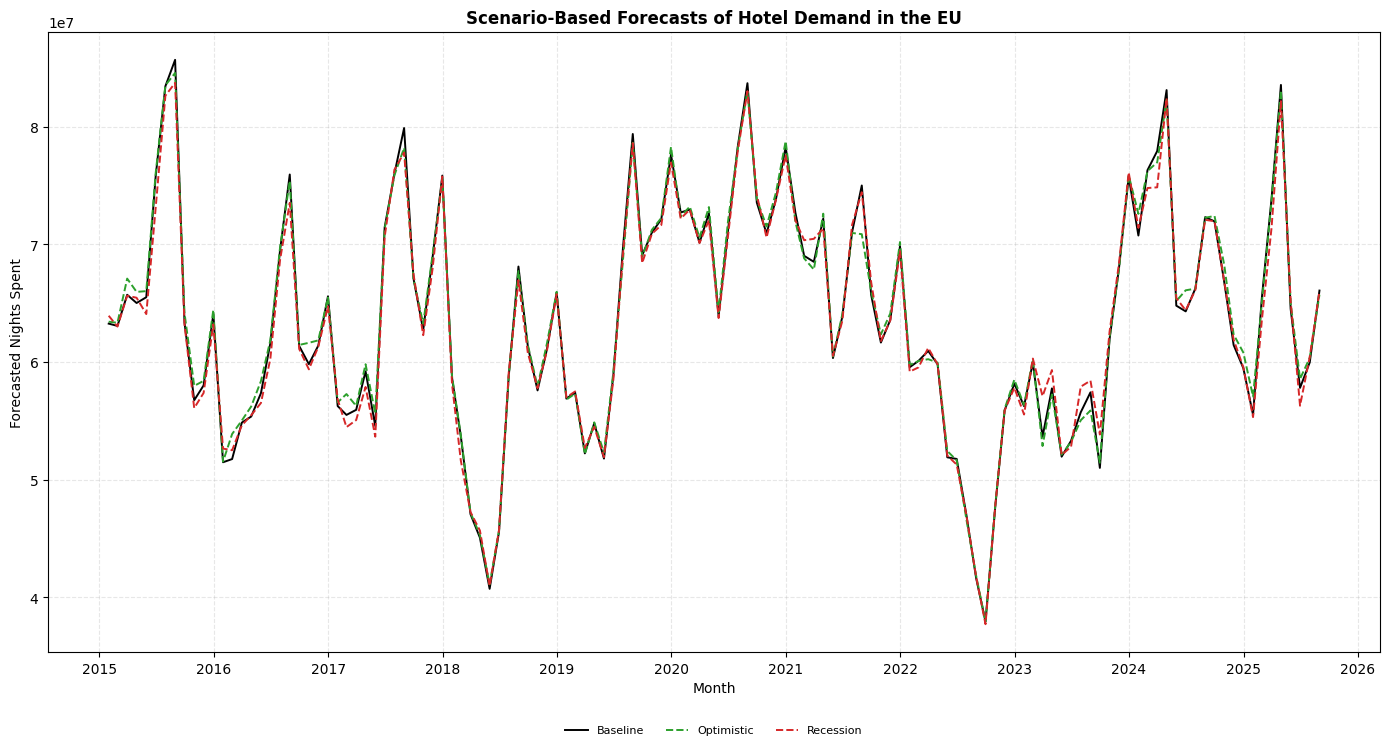

✅ Scenario forecasts plot saved → ../outputs/figures/hotel_scenario_forecasts.png


In [79]:
# %% ===============================================================
# STEP 4 — SCENARIO FORECASTS (Styled)
# ===============================================================

import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

plt.rcdefaults()

# --- Load and prepare data
forecast_path = DATA_PROCESSED / "hotel_scenario_forecasts.csv"
df = pd.read_csv(forecast_path, parse_dates=["month"])
df["yhat_avg"] = df[["yhat_xgb", "yhat_lgbm"]].mean(axis=1)

df_summary = (
    df.groupby(["scenario", "month"], as_index=False)["yhat_avg"]
    .sum()
    .rename(columns={"yhat_avg": "forecast_nights"})
)

# --- Style setup
colors = {"Baseline": "black", "Optimistic": "#2ca02c", "Recession": "#d62728"}
linestyles = {"Baseline": "-", "Optimistic": "--", "Recession": "--"}

# --- Plot
fig, ax = plt.subplots(figsize=(14, 8))
for scen in ["Baseline", "Optimistic", "Recession"]:
    subset = df_summary[df_summary["scenario"] == scen]
    ax.plot(
        subset["month"], subset["forecast_nights"],
        label=scen, color=colors[scen],
        linestyle=linestyles[scen], lw=1.4
    )

ax.set_title("Scenario-Based Forecasts of Hotel Demand in the EU", fontsize=12, fontweight="bold")
ax.set_xlabel("Month")
ax.set_ylabel("Forecasted Nights Spent")
ax.grid(alpha=0.3, linestyle="--")
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.legend(fontsize=8, loc="lower center", ncol=3, frameon=False, bbox_to_anchor=(0.5, -0.15))

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

print(f"✅ Scenario forecasts plot saved → {FIGURES / 'hotel_scenario_forecasts.png'}")

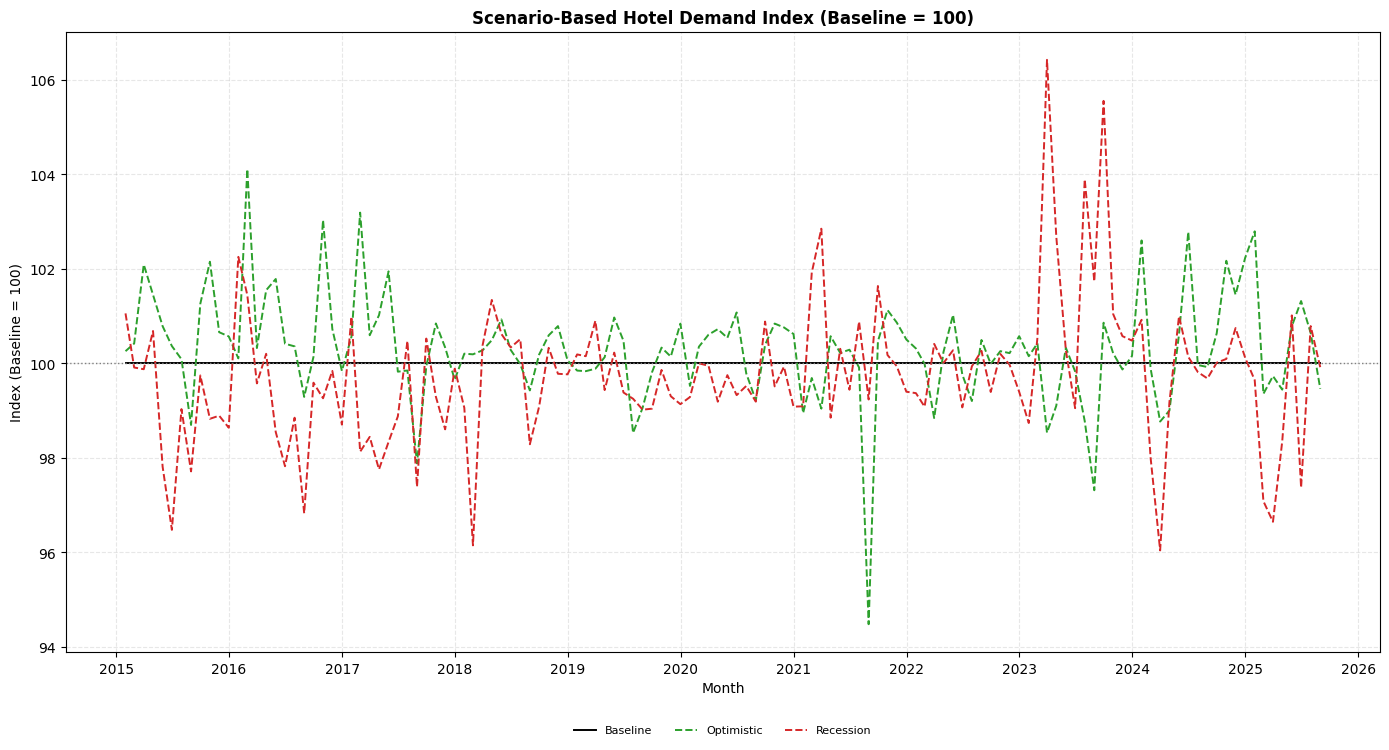

✅ Scenario index plot saved → ../outputs/figures/hotel_scenario_index_plot.png


In [ ]:
# %% ===============================================================
# STEP 4B — SCENARIO INDEX (Styled)
# ===============================================================

plt.rcdefaults()

# --- Load forecasts
forecast_path = DATA_PROCESSED / "hotel_scenario_forecasts.csv"
df = pd.read_csv(forecast_path, parse_dates=["month"])
df["yhat_avg"] = df[["yhat_xgb", "yhat_lgbm"]].mean(axis=1)

# --- Aggregate
df_summary = (
    df.groupby(["scenario", "month"], as_index=False)["yhat_avg"]
    .sum()
    .rename(columns={"yhat_avg": "forecast_nights"})
)

# --- Compute index vs Baseline (same month)
baseline_ref = (
    df_summary[df_summary["scenario"] == "Baseline"]
    .set_index("month")["forecast_nights"]
    .rename("baseline")
)
df_summary = df_summary.join(baseline_ref, on="month")
df_summary["index"] = (df_summary["forecast_nights"] / df_summary["baseline"]) * 100

# --- Style setup
colors = {"Baseline": "black", "Optimistic": "#2ca02c", "Recession": "#d62728"}
linestyles = {"Baseline": "-", "Optimistic": "--", "Recession": "--"}

# --- Plot
fig, ax = plt.subplots(figsize=(14, 8))
for scen in ["Baseline", "Optimistic", "Recession"]:
    subset = df_summary[df_summary["scenario"] == scen]
    ax.plot(
        subset["month"], subset["index"],
        label=scen, color=colors[scen],
        linestyle=linestyles[scen], lw=1.4
    )

ax.axhline(100, color="gray", lw=1, ls=":")
ax.set_title("Scenario-Based Hotel Demand Index (Baseline = 100)", fontsize=12, fontweight="bold")
ax.set_xlabel("Month")
ax.set_ylabel("Index (Baseline = 100)")
ax.grid(alpha=0.3, linestyle="--")
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.legend(fontsize=8, loc="lower center", ncol=3, frameon=False, bbox_to_anchor=(0.5, -0.15))

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

print(f"✅ Scenario index plot saved → {FIGURES / 'hotel_scenario_index_plot.png'}")

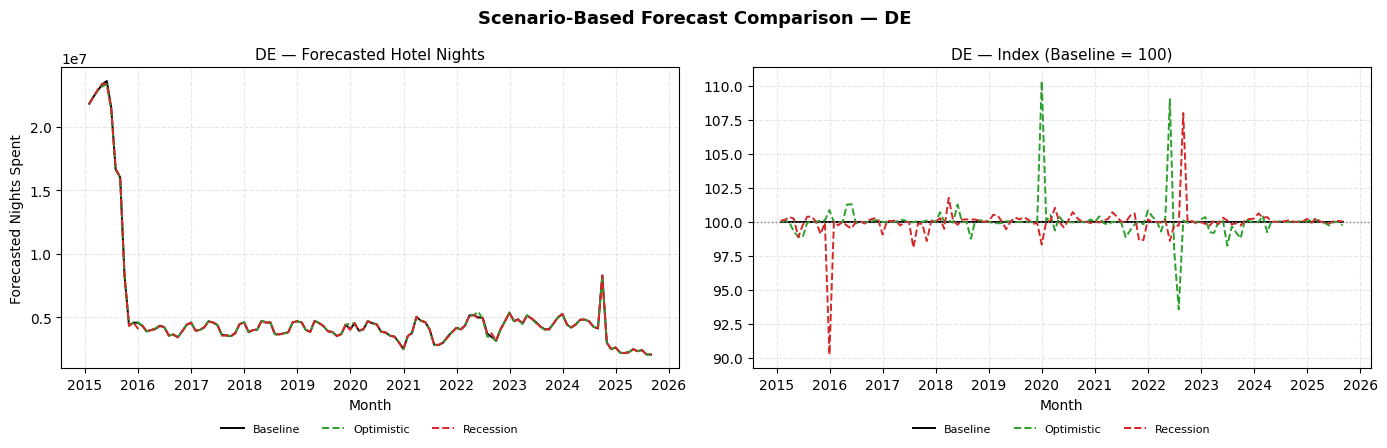

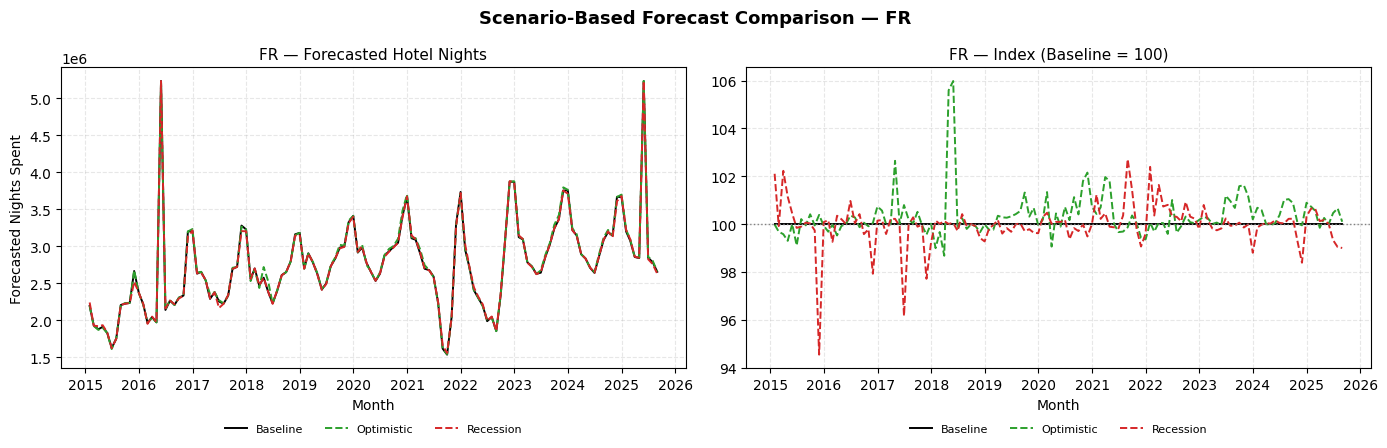

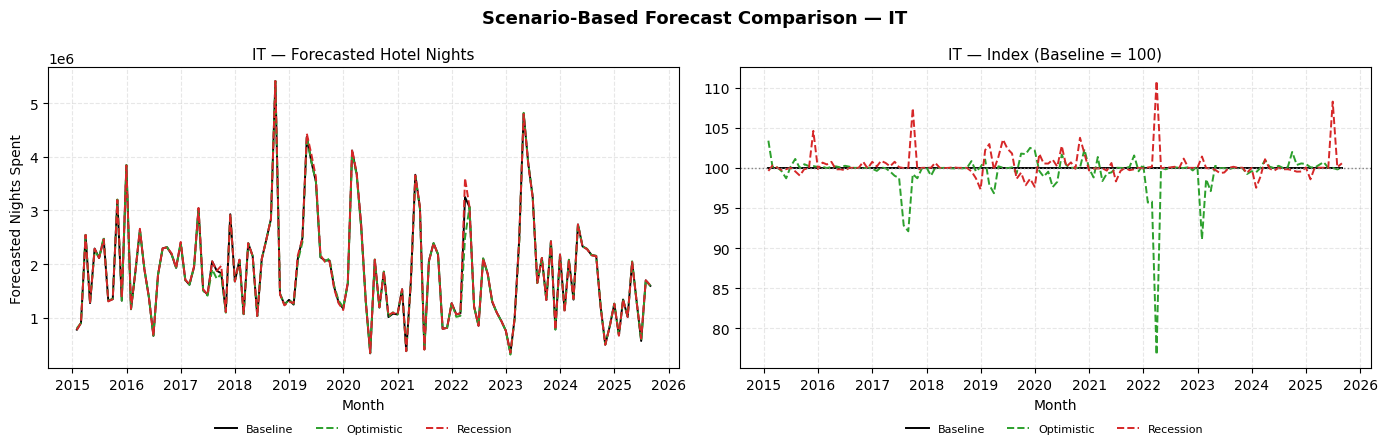

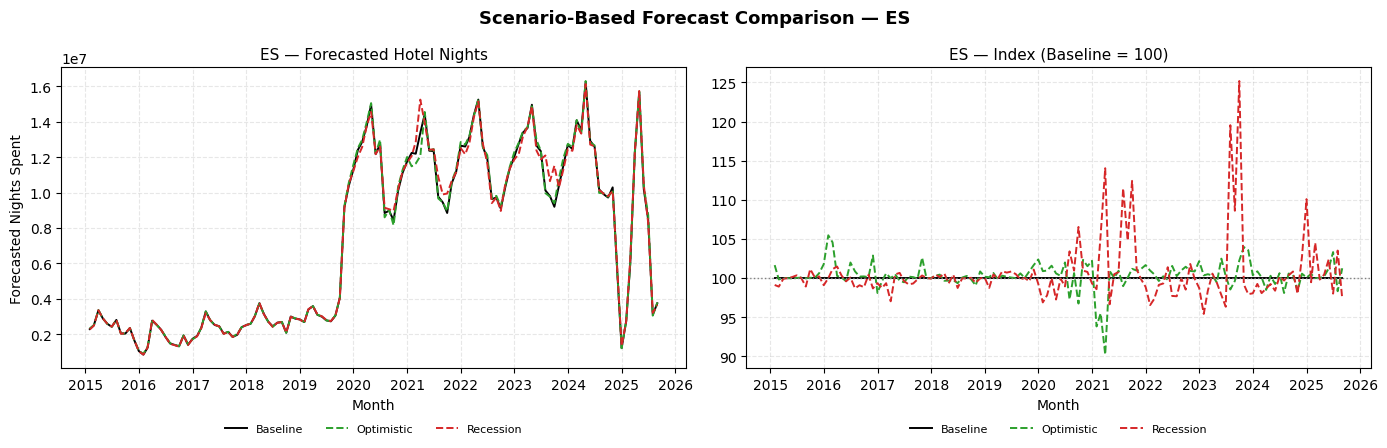

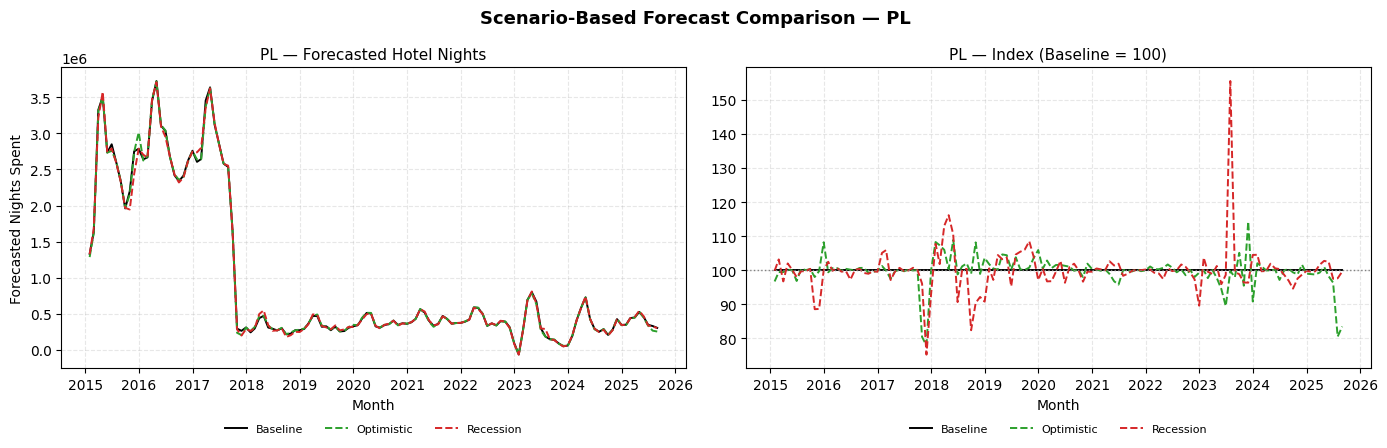

✅ Regional scenario forecast plots saved → /Users/golibsanaev/Library/CloudStorage/Dropbox/GitHub_gsanaev/forecasting-explaining-hotel-demand-in-eu/outputs/figures


In [ ]:
# %% ===============================================================
# STEP 5 — REGIONAL SCENARIO FORECASTS (ABSOLUTE + INDEX)
# Purpose: For top 5 countries, show absolute forecasts (left)
#          and relative index (right), consistent with STEP 4 + 4B style
# ===============================================================

plt.rcdefaults()

# --- Load scenario forecasts
forecast_path = DATA_PROCESSED / "hotel_scenario_forecasts.csv"
df = pd.read_csv(forecast_path, parse_dates=["month"])
df["yhat_avg"] = df[["yhat_xgb", "yhat_lgbm"]].mean(axis=1)

top_regions = ["DE", "FR", "IT", "ES", "PL"]

# --- Style
colors = {"Baseline": "black", "Optimistic": "#2ca02c", "Recession": "#d62728"}
linestyles = {"Baseline": "-", "Optimistic": "--", "Recession": "--"}

# --- Plot loop for each region
for region in top_regions:
    sub = df[df["region"] == region].copy()

    # Compute monthly baseline reference for index
    baseline = (
        sub[sub["scenario"] == "Baseline"]
        .set_index("month")["yhat_avg"]
        .rename("baseline")
    )
    sub = sub.join(baseline, on="month")
    sub["index"] = (sub["yhat_avg"] / sub["baseline"]) * 100

    # Two-panel layout
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

    # --- LEFT: Absolute Forecasted Nights
    for scen in ["Baseline", "Optimistic", "Recession"]:
        sdata = sub[sub["scenario"] == scen]
        axes[0].plot(
            sdata["month"], sdata["yhat_avg"],
            label=scen, color=colors[scen],
            linestyle=linestyles[scen], lw=1.4
        )
    axes[0].set_title(f"{region} — Forecasted Hotel Nights", fontsize=11)
    axes[0].set_xlabel("Month")
    axes[0].set_ylabel("Forecasted Nights Spent")
    axes[0].grid(alpha=0.3, linestyle="--")
    axes[0].xaxis.set_major_locator(mdates.YearLocator())
    axes[0].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

    # --- RIGHT: Index (Baseline = 100)
    for scen in ["Baseline", "Optimistic", "Recession"]:
        sdata = sub[sub["scenario"] == scen]
        axes[1].plot(
            sdata["month"], sdata["index"],
            label=scen, color=colors[scen],
            linestyle=linestyles[scen], lw=1.4
        )
    axes[1].axhline(100, color="gray", lw=1, ls=":")
    axes[1].set_title(f"{region} — Index (Baseline = 100)", fontsize=11)
    axes[1].set_xlabel("Month")
    axes[1].grid(alpha=0.3, linestyle="--")
    axes[1].xaxis.set_major_locator(mdates.YearLocator())
    axes[1].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

    # --- Legend and layout
    axes[0].legend(
        fontsize=8,
        loc="lower center", ncol=3,
        frameon=False, bbox_to_anchor=(0.5, -0.25)
    )
    
    # --- Legend and layout
    axes[1].legend(
        fontsize=8,
        loc="lower center", ncol=3,
        frameon=False, bbox_to_anchor=(0.5, -0.25)
    )

    plt.suptitle(
        f"Scenario-Based Forecast Comparison — {region}",
        fontsize=13, y=0.98, fontweight="bold"
    )
    plt.tight_layout(rect=[0, 0.05, 1, 1])

    # --- Save
    plot_path = FIGURES / f"scenario_forecast_comparison_{region}.png"
    plt.savefig(plot_path, dpi=300, bbox_inches="tight")
    plt.show()

print(f"✅ Regional scenario forecast plots saved → {FIGURES.resolve()}")

In [81]:
df[df["region"] == "DE"].groupby(df["month"].dt.year)["nights_spent"].sum()

month
2015    510284226.0
2016     24319908.0
2017     25328019.0
2018     25999554.0
2019     27311838.0
2020     25732857.0
2021     17887644.0
2022     32998593.0
2023     35507376.0
2024     26548890.0
2025      2920452.0
Name: nights_spent, dtype: float64

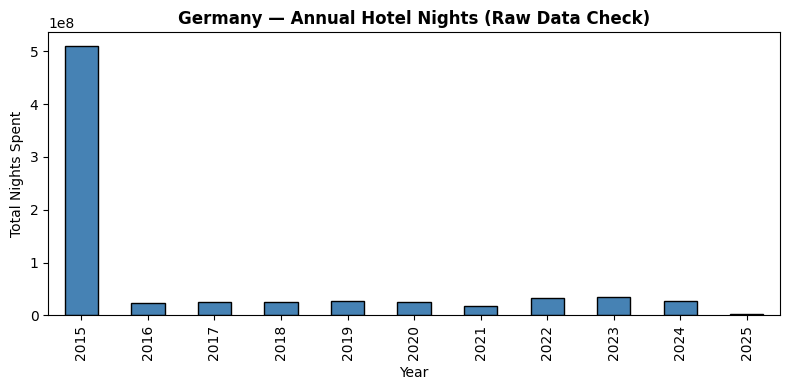

In [82]:
import matplotlib.pyplot as plt

df[df["region"] == "DE"].groupby(df["month"].dt.year)["nights_spent"].sum().plot(
    kind="bar", figsize=(8, 4), color="steelblue", edgecolor="black"
)
plt.title("Germany — Annual Hotel Nights (Raw Data Check)", fontsize=12, fontweight="bold")
plt.ylabel("Total Nights Spent")
plt.xlabel("Year")
plt.tight_layout()
plt.show()


In [83]:
df[df["region"] == "FR"].groupby(df["month"].dt.year)["nights_spent"].sum()

month
2015    10277418.0
2016    23726538.0
2017    32039205.0
2018    34009092.0
2019    36214644.0
2020    37341690.0
2021    29064522.0
2022    22186071.0
2023    35963322.0
2024    34878372.0
2025    19349226.0
Name: nights_spent, dtype: float64